# Neat Analysis

## <span style="color:red"> Do not open or modify this </span>

In [1]:
!pip install matplotlib

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
ROOT = Path.cwd()

while ROOT.name != "Market_Sizing" and ROOT != ROOT.parent:
    ROOT = ROOT.parent

DATA_DIR = ROOT / "Data"
DATA_DIR_2 = ROOT / "Data_Clean"

## <span style="color:blue"> Fonctions </span>

In [4]:
# Couleurs Neat 
c_fonce = '#41072A'
c_rose = '#FF85C8'    
c_clair = '#FFDEEF'
c_gris = '#F2EFF2'

In [5]:
def extraire_pays(valeur):
    if pd.isna(valeur) or valeur == "":
        return "Unknown"
    val_str = str(valeur)
    pays = val_str.replace('[', '').replace(']', '').split(',')[0].strip()
    return pays

In [6]:
KEEP_COLS = ["Name", "Revenue","HQ Location","LinkedIn URL","Website","Company description"]

def clean_df(df: pd.DataFrame, strict: bool = True) -> pd.DataFrame:

    df = df.copy()
    
    return df[KEEP_COLS]

In [7]:
def add_country(df: pd.DataFrame) -> pd.DataFrame:
    """Ajoute une colonne Country à partir de HQ Location (via extraire_pays)."""
    df = df.copy()
    if "HQ Location" in df.columns:
        df["Country"] = df["HQ Location"].apply(extraire_pays)
    else:
        df["Country"] = pd.NA
    return df

In [8]:
def coerce_revenue(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["Revenue"] = pd.to_numeric(df["Revenue"], errors="coerce")
    return df

In [9]:
def drop_nan_revenue_and_scale(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df_clean = df.dropna(subset=["Revenue"]).copy()
    df_clean["Revenue_M"] = df_clean["Revenue"] / 1_000_000
    return df_clean

In [10]:
def add_enrichment_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Ajoute les colonnes vides utilisées ensuite (pour enrichissement futur)."""
    df = df.copy()
    for col in ["Main Broker", "Main Insurer", "Hubspot"]:
        if col not in df.columns:
            df[col] = ""
    return df

In [11]:
def prepare_dataset(df: pd.DataFrame) -> tuple[pd.DataFrame, dict]:
    """
    Pipeline complet sur un df brut.
    Retourne: (df_clean, stats_de_base)
    """
    df0 = df.copy()
    df1 = add_country(df0)
    df2 = coerce_revenue(df1)

    nb_total_initial = len(df2)
    nb_nan = df2["Revenue"].isna().sum()

    df_clean = drop_nan_revenue_and_scale(df2)
    df_clean = add_enrichment_columns(df_clean)

    stats = {"nb_total_initial": nb_total_initial, "nb_nan_revenue": nb_nan}
    return df_clean, stats

In [12]:
def compute_kpis(df_clean: pd.DataFrame, stats_base: dict) -> dict:
    """Calcule les KPIs globaux."""
    total_rev = df_clean["Revenue_M"].sum()
    mediane_rev = df_clean["Revenue_M"].median()

    return {
        "nb_total_initial": stats_base["nb_total_initial"],
        "nb_nan_revenue": stats_base["nb_nan_revenue"],
        "total_rev_m": total_rev,
        "mediane_rev_m": mediane_rev,
    }

In [13]:
def kpi_table(kpis: dict) -> pd.DataFrame:
    """Transforme les KPIs en tableau affichable."""
    return pd.DataFrame({
        "Indicateur": [
            "Nombre d'entreprises total",
            "Entreprises sans revenus visibles (NaN)",
            "Revenu Total (M$)",
            "Revenu Médian (M$)"
        ],
        "Valeur": [
            f"{kpis['nb_total_initial']}",
            f"{kpis['nb_nan_revenue']}",
            f"{kpis['total_rev_m']:,.2f}",
            f"{kpis['mediane_rev_m']:,.2f}",
        ]
    })

In [14]:
DEFAULT_BINS_LABELS = [
    "Revenues below 1M$",
    "Revenues between 1 and 10 M$",
    "Revenues between 10 and 25 M$",
    "Revenues between 25 and 50 M$",
    "Revenues over 50 M$"
]

In [15]:
def add_revenue_bucket(df_clean: pd.DataFrame, labels=DEFAULT_BINS_LABELS) -> pd.DataFrame:
    """Ajoute la colonne Criteria (tranches) selon Revenue_M."""
    df = df_clean.copy()
    df["Criteria"] = np.select(
        [
            df["Revenue_M"] < 1,
            (df["Revenue_M"] >= 1) & (df["Revenue_M"] < 10),
            (df["Revenue_M"] >= 10) & (df["Revenue_M"] < 25),
            (df["Revenue_M"] >= 25) & (df["Revenue_M"] < 50),
            df["Revenue_M"] >= 50,
        ],
        labels,
        default="Unknown"
    )
    return df

In [16]:
def bucket_summary(df_clean: pd.DataFrame, labels=DEFAULT_BINS_LABELS) -> pd.DataFrame:
    """Retourne un résumé (nb + parts) par tranche."""
    df = add_revenue_bucket(df_clean, labels=labels)

    summary = df["Criteria"].value_counts().reset_index()
    summary.columns = ["Criteria", "Nb of companies"]
    summary["Criteria"] = pd.Categorical(summary["Criteria"], categories=labels, ordered=True)
    summary = summary.sort_values("Criteria")
    summary["Shares"] = (summary["Nb of companies"] / len(df) * 100).round(1).astype(str) + "%"
    return summary

In [17]:
def top_n_companies(df_clean: pd.DataFrame, n: int = 20) -> tuple[pd.DataFrame, float]:
    """Retourne le top N avec parts de marché + somme du top N."""
    df = df_clean.copy()
    total_rev = df["Revenue_M"].sum()

    top = df.sort_values(by="Revenue_M", ascending=False).head(n).copy()
    top["Market Share"] = (top["Revenue_M"] / total_rev * 100).round(2).astype(str) + "%"
    top["Revenue"] = top["Revenue_M"].round(0).astype(int)  # en M$

    somme_top = top["Revenue_M"].sum()
    cols = ["Name", "Revenue", "Market Share", "Main Broker", "Main Insurer", "Country"]
    return top[cols], somme_top


In [18]:
def clean_and_save_df(df, filename, output_dir="Data_Clean"):
    if isinstance(df, tuple):
        df = df[0]

    df_clean = clean_df(df)
    df_clean = add_country(df_clean)
    df_clean = coerce_revenue(df_clean)
    df_clean = drop_nan_revenue_and_scale(df_clean)
    df_clean = add_enrichment_columns(df_clean)

    from pathlib import Path
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    output_path = output_dir / f"{filename}.csv"
    df_clean.to_csv(output_path, index=False)

    print(f"✅ Saved: {output_path}")
    return


In [19]:
def analyse_de_marche_data(dict_bases: dict[str, pd.DataFrame], n_top: int = 20):
    """Boucle sur tes datasets, calcule et affiche."""
    for nom_affiche, df in dict_bases.items():
        df_clean, stats_base = prepare_dataset(df)
        kpis = compute_kpis(df_clean, stats_base)

        print(f"\n{'='*40}\nANALYSE : {nom_affiche.upper()}\n{'='*40}")
        print("TABLEAU DE BORD SYNTHÉTIQUE :")
        display(kpi_table(kpis))
        print("-" * 40)

        print("\nREPARTITION PAR TRANCHE :")
        display(bucket_summary(df_clean))

        print(f"\nTOP {n_top} DES ENTREPRISES :")
        top, somme_top = top_n_companies(df_clean, n=n_top)
        display(top)
        print(f"Somme des revenus du Top {n_top} : {somme_top:,.0f} M$")

In [20]:
def add_sector(df: pd.DataFrame, sector_name: str) -> pd.DataFrame:
    df = df.copy()
    df["Sector"] = sector_name
    return df

In [21]:
def prepare_sector_df(df: pd.DataFrame, sector_name: str) -> pd.DataFrame:
    """Prépare un df de secteur avant concat."""
    df = add_sector(df, sector_name)
    df = add_country_from_hq(df)
    return df

In [22]:
def build_panorama(dict_bases: dict[str, pd.DataFrame]) -> pd.DataFrame:
    """Concatène tous les secteurs en un panorama."""
    frames = [prepare_sector_df(df, sector) for sector, df in dict_bases.items()]
    return pd.concat(frames, ignore_index=True)

In [23]:
def compute_market_totals(df_panorama: pd.DataFrame) -> float:
    return df_panorama["Revenue_M"].sum()

In [24]:
def generer_panorama_final(dict_bases, nom_marche):

    if isinstance(dict_bases, pd.DataFrame):
        dict_bases = {"All": dict_bases}

    all_data = []
    for nom_secteur, df in dict_bases.items():
        temp_df = df.copy()
        temp_df['Sector'] = nom_secteur
    
        if 'Locations' in temp_df.columns:
            temp_df['Country'] = temp_df['HQ Location'].apply(extraire_pays)
        else:
            temp_df['Country'] = "Unknown"
            
        all_data.append(temp_df)
    
    df_panorama = pd.concat(all_data, ignore_index=True)
    
    # Cleaning des revenus
    df_panorama['Revenue'] = pd.to_numeric(df_panorama['Revenue'], errors='coerce')
    df_panorama = df_panorama.dropna(subset=['Revenue'])
    df_panorama['Revenue_M'] = df_panorama['Revenue'] / 1000000
    
    # Statistiques pour le dashboard
    total_market = df_panorama['Revenue_M'].sum()
    sector_summary = df_panorama.groupby('Sector')['Revenue_M'].sum().sort_values(ascending=True)
    country_summary = df_panorama.groupby('Country')['Revenue_M'].sum().sort_values(ascending=False).head(10)
    
    top_20 = df_panorama.sort_values(by='Revenue_M', ascending=False).head(20)
    somme_top20 = top_20['Revenue_M'].sum()

    # Dashboard final
    fig = plt.figure(figsize=(18, 16))
    fig.patch.set_facecolor('white')
    plt.suptitle(f"Strategic Overview of the Market {nom_marche.upper()}\nTotal Volume Analyzed: ${total_market:,.0f}m", 
                 fontsize=22, color=c_fonce, fontweight='bold', y=0.98)

    # Graphique 1 : Poids des Secteurs
    ax1 = plt.subplot(3, 2, 1)
    ax1.barh(sector_summary.index, sector_summary.values, color=c_rose, edgecolor=c_fonce, alpha=0.8)
    ax1.set_title("Market Size by Segment", fontsize=15, color=c_fonce, pad=15, fontweight='bold')
    for i, v in enumerate(sector_summary.values):
        ax1.text(v + (total_market*0.005), i, f"{v:,.0f} $m", color=c_fonce, va='center', fontweight='bold')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Graphique 2 : Concentration
    ax2 = plt.subplot(3, 2, 2)
    sizes = [somme_top20, total_market - somme_top20]
    ax2.pie(sizes, labels=['Top 20 Leaders', 'Reste du Marché'], autopct='%1.1f%%', 
            startangle=140, colors=[c_fonce, c_clair], pctdistance=0.75, 
            textprops={'color': c_fonce, 'fontweight': 'bold'})
    center_circle = plt.Circle((0,0), 0.60, fc='white')
    ax2.add_artist(center_circle)
    ax2.set_title("Market Revenue Concentration", fontsize=15, color=c_fonce, fontweight='bold')

    # Graphique 3 : Top 10 Pays
    ax3 = plt.subplot(3, 2, 3)
    ax3.bar(country_summary.index, country_summary.values, color=c_rose, alpha=0.6)
    ax3.set_title("Top 10 Countries by Total Revenue ($m)", fontsize=15, color=c_fonce, fontweight='bold')
    plt.xticks(rotation=45)
    ax3.set_ylabel("M$")

    # Graphique 4 : Top 10 Leaders
    ax4 = plt.subplot(3, 2, 4)
    top_10 = top_20.head(10).sort_values(by='Revenue_M', ascending=True)
    ax4.barh(top_10['Name'], top_10['Revenue_M'], color=c_fonce)
    ax4.set_title("Top 10 Global Players by Revenue ($m)", fontsize=15, color=c_fonce, fontweight='bold')
    ax4.grid(axis='x', linestyle='--', alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## <span style="color:blue"> Travel Analysis </span>

### Airline - France

In [25]:
airline_france = pd.read_csv(DATA_DIR / "AirlineFrance.csv")

In [26]:
noms_a_supprimer_airline_france = ['Servair','Worldwide Flight Services','OYONNAIR','Get1Jet','Aigle Azur']

In [27]:
airline_france = airline_france[~airline_france["Name"].isin(noms_a_supprimer_airline_france)].copy()

In [28]:
clean_and_save_df(airline_france,
    "travel_airline_france_cleaned")

✅ Saved: Data_Clean/travel_airline_france_cleaned.csv


### Airline - EU

In [29]:
airline_eu = pd.read_csv(DATA_DIR / "Airline - EU.csv")

In [30]:
noms_a_supprimer_airline_eu = ['Ferrovial S.E.','AerCap Holdings','Lufthansa Group Business Services']

In [31]:
airline_eu = airline_eu[~airline_eu["Name"].isin(noms_a_supprimer_airline_eu)].copy()

In [32]:
clean_and_save_df(airline_eu,
    "travel_airline_europe_cleaned")

✅ Saved: Data_Clean/travel_airline_europe_cleaned.csv


### Hotel - France

In [33]:
Hotel_France = pd.read_csv(DATA_DIR /"Hotel - France.csv")

In [34]:
clean_and_save_df(Hotel_France,
    "travel_hotel_france_cleaned")

✅ Saved: Data_Clean/travel_hotel_france_cleaned.csv


### Hotel - EU

In [35]:
Hotel_EU = pd.read_csv(DATA_DIR /"Hotel_EU.csv")

In [36]:
noms_a_supprimer_hotel_eu = ["Koninklijke Horeca Nederland","DEHOGA Baden-Württemberg","Thon Gruppen","A. Ahlström","The Ritz-Carlton Hotel Company L.L.C."]

In [37]:
Hotel_EU = Hotel_EU[~Hotel_EU["Name"].isin(noms_a_supprimer_hotel_eu)].copy()

In [38]:
mask = Hotel_EU["Name"].isin(["NH Hotel Group S.A.", "NH Hotel Group"])

total_revenue = Hotel_EU.loc[mask, "Revenue"].sum()

Hotel_EU = Hotel_EU[~mask]

Hotel_EU = pd.concat([Hotel_EU,pd.DataFrame([{"Name": "NH Hotel Group", "Revenue": total_revenue,}])], ignore_index=True)

In [39]:
clean_and_save_df(Hotel_EU,
    "travel_hotel_europe_cleaned")

✅ Saved: Data_Clean/travel_hotel_europe_cleaned.csv


### Transportation - EU

In [40]:
train_europe = pd.read_csv(DATA_DIR /"Trains - Europe.csv")
ferry_europe = pd.read_csv(DATA_DIR /"Ferry - Europe.csv")
cruise_europe = pd.read_csv(DATA_DIR /"Cruise - Europe.csv")

In [41]:
Transportation_EU = pd.concat([train_europe, ferry_europe,cruise_europe],ignore_index=True)

In [42]:
clean_and_save_df(Transportation_EU,
    "travel_transportation_europe_cleaned")

✅ Saved: Data_Clean/travel_transportation_europe_cleaned.csv


### Transportation France

In [43]:
Transportation_France = pd.read_csv(DATA_DIR /"Cruise, Ferry, Train - France.csv")

In [44]:
noms_a_supprimer_transportation_france = ['DB Cargo France','NAVILAND CARGO','BARAT Group','Move Expert']

In [45]:
Transportation_France = Transportation_France[~Transportation_France["Name"].isin(noms_a_supprimer_transportation_france)].copy()

### Conciergerie - France

In [46]:
Conciergerie_France = pd.read_csv(DATA_DIR /"Conciergerie - France.csv")

In [47]:
noms_a_supprimer_conciergerie_france = ["CIVIS Protection Juridique","SPI - Septeo Pôle Immobilier"]

In [48]:
Conciergerie_France = Conciergerie_France[~Conciergerie_France["Name"].isin(noms_a_supprimer_conciergerie_france)].copy()

In [49]:
clean_and_save_df(Conciergerie_France,
    "travel_conciergerie_france_cleaned")

✅ Saved: Data_Clean/travel_conciergerie_france_cleaned.csv


### Conciergerie - EU

In [50]:
Conciergerie_EU = pd.read_csv(DATA_DIR /"Conciergerie - EU.csv")

In [51]:
clean_and_save_df(Conciergerie_EU,
    "travel_conciergerie_europe_cleaned")

✅ Saved: Data_Clean/travel_conciergerie_europe_cleaned.csv


### Car Rental - France

In [52]:
Car_Rental_France = pd.read_csv(DATA_DIR /"Car rental - France.csv")

In [53]:
clean_and_save_df(Car_Rental_France,
    "travel_carrental_france_cleaned")

✅ Saved: Data_Clean/travel_carrental_france_cleaned.csv


### Car Rental - EU

In [54]:
Car_Rental_EU = pd.read_csv(DATA_DIR /"Car rental - EU.csv")

In [55]:
noms_a_supprimer_car_rental_eu = ["DEKRA Expertise España","InterTech","OKQ8","GROB-WERKE GmbH & Co. KG","Carclasse","BMW Group France","NKD Group","E.G.O.-Group","Scherer Gruppe","SAGA Mercedes-Benz","Noot Personenvervoer"]

In [56]:
Car_Rental_EU = Car_Rental_EU[~Car_Rental_EU["Name"].isin(noms_a_supprimer_car_rental_eu)].copy()

In [57]:
clean_and_save_df(Car_Rental_EU,
    "travel_carrental_europe_cleaned")

✅ Saved: Data_Clean/travel_carrental_europe_cleaned.csv


### Vacances - France

In [58]:
Vacances_France = pd.read_csv(DATA_DIR /"Club vacance, OTA et TO - France.csv")

In [59]:
noms_a_supprimer_vacances_france = ["Eden Rock - St Barths","PEP Brétill'Armor"]

In [60]:
Vacances_France = Vacances_France[~Vacances_France["Name"].isin(noms_a_supprimer_vacances_france)].copy()

In [61]:
ligne_a_transferer = Transportation_France[Transportation_France['Name'] == 'Leclerc Voyages']

In [62]:
Vacances_France = pd.concat([Vacances_France, ligne_a_transferer],ignore_index=True)

In [63]:
Transportation_France.drop(Transportation_France[ Transportation_France['Name'] == 'Leclerc Voyages' ].index, inplace=True)

In [64]:
clean_and_save_df(Vacances_France,
    "travel_vacances_france_cleaned")

✅ Saved: Data_Clean/travel_vacances_france_cleaned.csv


In [65]:
clean_and_save_df(Transportation_France,
    "travel_transportation_france_cleaned")

✅ Saved: Data_Clean/travel_transportation_france_cleaned.csv


### Vacances - EU

In [66]:
Vacances_EU = pd.read_csv(DATA_DIR /"Club vacance, OTA et TO - EU.csv")

In [67]:
noms_a_supprimer_vacances_eu = ["Meeting Point International","Travel Compositor","NOZ/mh N MEDIEN","GetYourGuide","PAYBACK Österreich"]

In [68]:
Vacances_EU = Vacances_EU[~Vacances_EU["Name"].isin(noms_a_supprimer_vacances_eu)].copy()

In [69]:
clean_and_save_df(Vacances_EU,
    "travel_vacances_europe_cleaned")

✅ Saved: Data_Clean/travel_vacances_europe_cleaned.csv


## <span style="color:blue"> Financial Services Analysis </span>

### Energies - France

In [70]:
Energies_France = pd.read_csv(DATA_DIR /"Energies - France.csv")

In [71]:
clean_and_save_df(Energies_France,
    "financial_services_energies_france_cleaned")

✅ Saved: Data_Clean/financial_services_energies_france_cleaned.csv


### Energies - EU

In [72]:
Energies_EU = pd.read_csv(DATA_DIR /"Energies - EU.csv")

In [73]:
clean_and_save_df(Energies_EU,
    "financial_services_energies_europe_cleaned")

✅ Saved: Data_Clean/financial_services_energies_europe_cleaned.csv


### Fintech et Néobanque - France

In [74]:
noms_a_supprimer_fintech_france  = ["Arkéa Banking Services", "Galitt","Oaklen Consulting"]

In [75]:
Fintech_France = pd.read_csv(DATA_DIR /"Fintech et Néobanque - France.csv")

In [76]:
Fintech_France = Fintech_France[~Fintech_France["Name"].isin(noms_a_supprimer_fintech_france)].copy()

In [77]:
clean_and_save_df(Fintech_France,
    "financial_services_fintech_france_cleaned")

✅ Saved: Data_Clean/financial_services_fintech_france_cleaned.csv


### Fintech et Néobanque - Eu

In [78]:
Fintech_EU = pd.read_csv(DATA_DIR /"Fintech et Néobaque - EU.csv")

In [79]:
noms_a_supprimer_fintech_EU  = ["Crunch - Software Development And AI Expertise","BDO Germany"]

In [80]:
Fintech_EU = Fintech_EU[~Fintech_EU["Name"].isin(noms_a_supprimer_fintech_EU)].copy()

In [81]:
clean_and_save_df(Fintech_EU,
    "financial_services_fintech_europe_cleaned")

✅ Saved: Data_Clean/financial_services_fintech_europe_cleaned.csv


## <span style="color:blue"> Consumer Goods Analysis </span>

### Ameublement - France

In [82]:
Ameublement_France = pd.read_csv(DATA_DIR /"Ameublement - France.csv")

In [83]:
clean_and_save_df(Ameublement_France,
    "goods_ameublement_france_cleaned")

✅ Saved: Data_Clean/goods_ameublement_france_cleaned.csv


### Ameublement_EU

In [162]:
Ameublement_EU = pd.read_csv(DATA_DIR /"Ameublement - EU.csv")

In [163]:
clean_and_save_df(Ameublement_EU,
    "goods_ameublement_europe_cleaned")

✅ Saved: Data_Clean/goods_ameublement_europe_cleaned.csv


### Telecom + Elec - France

In [86]:
Telelec_France = pd.read_csv(DATA_DIR /"Telelec - France.csv")

In [87]:
clean_and_save_df(Telelec_France,
    "goods_telelec_france_cleaned")

✅ Saved: Data_Clean/goods_telelec_france_cleaned.csv


### Telecom + Elec - EU

In [88]:
Telelec_EU_1 = pd.read_csv(DATA_DIR /"Retail - Telco + Electroménager - EU - Lot 1.csv")
Telelec_EU_2 = pd.read_csv(DATA_DIR /"Retail - Telco + Electroménager - EU - Lot 2.csv")

In [89]:
listetelelec_EU = [Telelec_EU_1, Telelec_EU_2]

In [90]:
Telelec_EU = pd.concat(listetelelec_EU, ignore_index = True)

In [91]:
clean_and_save_df(Telelec_EU,
    "goods_telelec_europe_cleaned")

✅ Saved: Data_Clean/goods_telelec_europe_cleaned.csv


### Cuisiniste - France

In [92]:
Cuisiniste_France = pd.read_csv(DATA_DIR /"Cuisiniste - France.csv")

In [93]:
clean_and_save_df(Cuisiniste_France,
    "goods_cuisiniste_france_cleaned")

✅ Saved: Data_Clean/goods_cuisiniste_france_cleaned.csv


### Cuisiniste - EU

In [94]:
Cuisiniste_EU = pd.read_csv(DATA_DIR /"Cuisiniste - EU.csv")

In [95]:
clean_and_save_df(Cuisiniste_EU,
    "goods_cuisiniste_europe_cleaned")

✅ Saved: Data_Clean/goods_cuisiniste_europe_cleaned.csv


### Bricolage - France

In [149]:
Bricolage_France = pd.read_csv(DATA_DIR / "Bricolage - France.csv")

In [151]:
noms_a_supprimer_bricolage_france = ["Hautes Terres Communauté"]

In [152]:
Bricolage_France = Bricolage_France[~Bricolage_France["Name"].isin(noms_a_supprimer_bricolage_france)].copy()

In [166]:
clean_and_save_df(Bricolage_France,
    "goods_bricolage_france_cleaned")

✅ Saved: Data_Clean/goods_bricolage_france_cleaned.csv


### Bricolage - EU

In [158]:
Bricolage_EU = pd.read_csv(DATA_DIR / "Bricolage - EU.csv")

In [159]:
mask = Bricolage_EU["Name"].isin(["HORNBACH Baumarkt AG", "Hornbach Holding AG &amp; Co. KGaA"])

total_revenue = Bricolage_EU.loc[mask, "Revenue"].sum()

Bricolage_EU = Bricolage_EU[~mask]

Bricolage_EU = pd.concat([Bricolage_EU,pd.DataFrame([{"Name": "HORNBACH Baumarkt AG", "Revenue": total_revenue,}])], ignore_index=True)

In [160]:
Bricolage_EU.loc[
    Bricolage_EU["Name"] == "HORNBACH Baumarkt AG",
    "HQ Location"
] = "Germany"

In [161]:
clean_and_save_df(Bricolage_EU, "goods_bricolage_europe_cleaned")

✅ Saved: Data_Clean/goods_bricolage_europe_cleaned.csv


### Optique et Audio - France

In [101]:
Optique_Audio_France = pd.read_csv(DATA_DIR / "Optique et Audio - France.csv")

In [102]:
clean_and_save_df(Optique_Audio_France, "goods_optiqueaudio_france_cleaned")

✅ Saved: Data_Clean/goods_optiqueaudio_france_cleaned.csv


### Optique et Audio - Europe

In [103]:
Optique_Audio_Europe = pd.read_csv(DATA_DIR / "Optique et Audio - EU.csv")

In [104]:
clean_and_save_df(Optique_Audio_Europe, "goods_optiqueaudio_europe_cleaned")

✅ Saved: Data_Clean/goods_optiqueaudio_europe_cleaned.csv


### Pneu - France

In [133]:
Pneu_France = pd.read_csv(DATA_DIR / "Pneu - France.csv")

In [134]:
noms_a_supprimer_pneu_france = ["Groupement Des Mousquetaires"]

In [135]:
Pneu_France = Pneu_France[~Pneu_France["Name"].isin(noms_a_supprimer_pneu_france)].copy()

In [136]:
clean_and_save_df(Pneu_France, "goods_pneu_france_cleaned")

✅ Saved: Data_Clean/goods_pneu_france_cleaned.csv


## <span style="color:blue"> Ticketing </span>

### Ticketing - France

In [107]:
Ticketing_France = pd.read_csv(DATA_DIR /"Ticketing - France.csv")

In [108]:
clean_and_save_df(Ticketing_France,
    "ticketing_ticketing_france_cleaned")

✅ Saved: Data_Clean/ticketing_ticketing_france_cleaned.csv


### Ticketing - EU

In [109]:
Ticketing_Eu = pd.read_csv(DATA_DIR /"Ticketing - EU.csv")

In [110]:
clean_and_save_df(Ticketing_Eu,
    "ticketing_ticketing_europe_cleaned")

✅ Saved: Data_Clean/ticketing_ticketing_europe_cleaned.csv


## <span style="color:blue"> Listes </span>

In [111]:
data = {
    "Airlines France": airline_france,
    "Airlines Europe": airline_eu,
    "Transportation Europe": Transportation_EU,
    "Transportation France" : Transportation_France,
    "Hôtels France": Hotel_France,
    "Hôtels EU": Hotel_EU,
    "Conciergerie France": Conciergerie_France,
    "Conciergerie Europe": Conciergerie_EU,
    "Club Vacances France": Vacances_France,
    "Club Vacances Europe": Vacances_EU,
    "Location de voitures France": Car_Rental_France,
    "Location de voitures Europe": Car_Rental_EU,
    "Ticketing France" : Ticketing_France,
    "Ticketing EU" : Ticketing_Eu,
    "Cuisinistes France": Cuisiniste_France,
    "Cuisinistes Europe": Cuisiniste_EU,
    "Ameublement France": Ameublement_France,
    "Ameublement Europe": Ameublement_EU,
    "Telcom + Eléctroménager France": Telelec_France,
    "Telcom + Eléctroménager EU": Telelec_EU,
    "Énergies France": Energies_France,
    "Énergies Europe": Energies_EU,
    "Fintech France": Fintech_France,
    "Fintech Europe": Fintech_EU
}

In [112]:
data_travel = {
    "Airlines France": airline_france,
    "Airlines Europe": airline_eu,
    "Transportation Europe": Transportation_EU,
    "Hôtels France": Hotel_France,
    "Hôtels Europe" : Hotel_EU,
    "Conciergerie France": Conciergerie_France,
    "Conciergerie Europe": Conciergerie_EU,
    "Club Vacances France": Vacances_France,
    "Club Vacances Europe": Vacances_EU,
    "Location de voitures France": Car_Rental_France,
    "Location de voitures Europe": Car_Rental_EU
}

In [113]:
data_airline = {
    "Airlines France": airline_france,
    "Airlines Europe": airline_eu
}

In [114]:
data_transportation = {
    "Transportation Europe": Transportation_EU,
    "Transportation France": Transportation_France
}

In [115]:
data_hotel = {
    "Hôtels France": Hotel_France,
    "Hôtels Europe" : Hotel_EU
}

In [116]:
data_conciergerie = {
    "Conciergerie France": Conciergerie_France,
    "Conciergerie Europe": Conciergerie_EU
}

In [117]:
data_vacances = {
    "Club Vacances France": Vacances_France,
    "Club Vacances Europe": Vacances_EU
}

In [118]:
data_carrental = {
    "Location de voitures France": Car_Rental_France,
    "Location de voitures Europe": Car_Rental_EU
}

In [119]:
data_ticketing = {
    "Ticketing France": Ticketing_France, 
    "Ticketing Europe": Ticketing_Eu
}

In [120]:
data_travel_liste = [data_airline, data_transportation, data_hotel, data_conciergerie, data_vacances, data_carrental, data_ticketing]

In [164]:
data_goods = {
    "Cuisinistes France": Cuisiniste_France,
    "Cuisinistes Europe": Cuisiniste_EU,
    "Ameublement France": Ameublement_France,
    "Ameublement Europe": Ameublement_EU,
    "Telecom + Electroménager France": Telelec_France,
    "Telecom + Electroménager EU": Telelec_EU,
    "Bricolage France":Bricolage_France,
    "Bricolage Europe": Bricolage_EU,
    "Audio et Optique France": Optique_Audio_France,
    "Audio et Optique Europe": Optique_Audio_Europe,
    "Pneu France" : Pneu_France
             }

In [127]:
data_pneu = {
    "Pneu France" : Pneu_France
}

In [ ]:
data_audio = {
    "Audio et Optique France": Optique_Audio_France,
    "Audio et Optique Europe": Optique_Audio_Europe
}

In [ ]:
data_cuisinistes = {
    "Cuisinistes France": Cuisiniste_France,
    "Cuisinistes Europe": Cuisiniste_EU,
}

In [ ]:
data_ameublement = {
    "Ameublement France": Ameublement_France,
    "Ameublement Europe": Ameublement_EU,
}

In [ ]:
data_telecom_electroménager = {
    "Telecom + Electroménager France": Telelec_France,
    "Telecom + Electroménager EU": Telelec_EU,
}

In [ ]:
data_bricolage = {
    "Bricolage France": Bricolage_France, 
    "Bricolage Europe": Bricolage_EU
}

In [ ]:
data_finance = { 
    "Énergies France": Energies_France,
    "Énergies Europe": Energies_EU,
    "Fintech France": Fintech_France,
    "Fintech Europe": Fintech_EU}

In [ ]:
data_europe = {}
    

In [ ]:
data_france = {}
    

## <span style="color:blue"> Execution </span>

In [ ]:
analyse_de_marche_data(data_pneu)

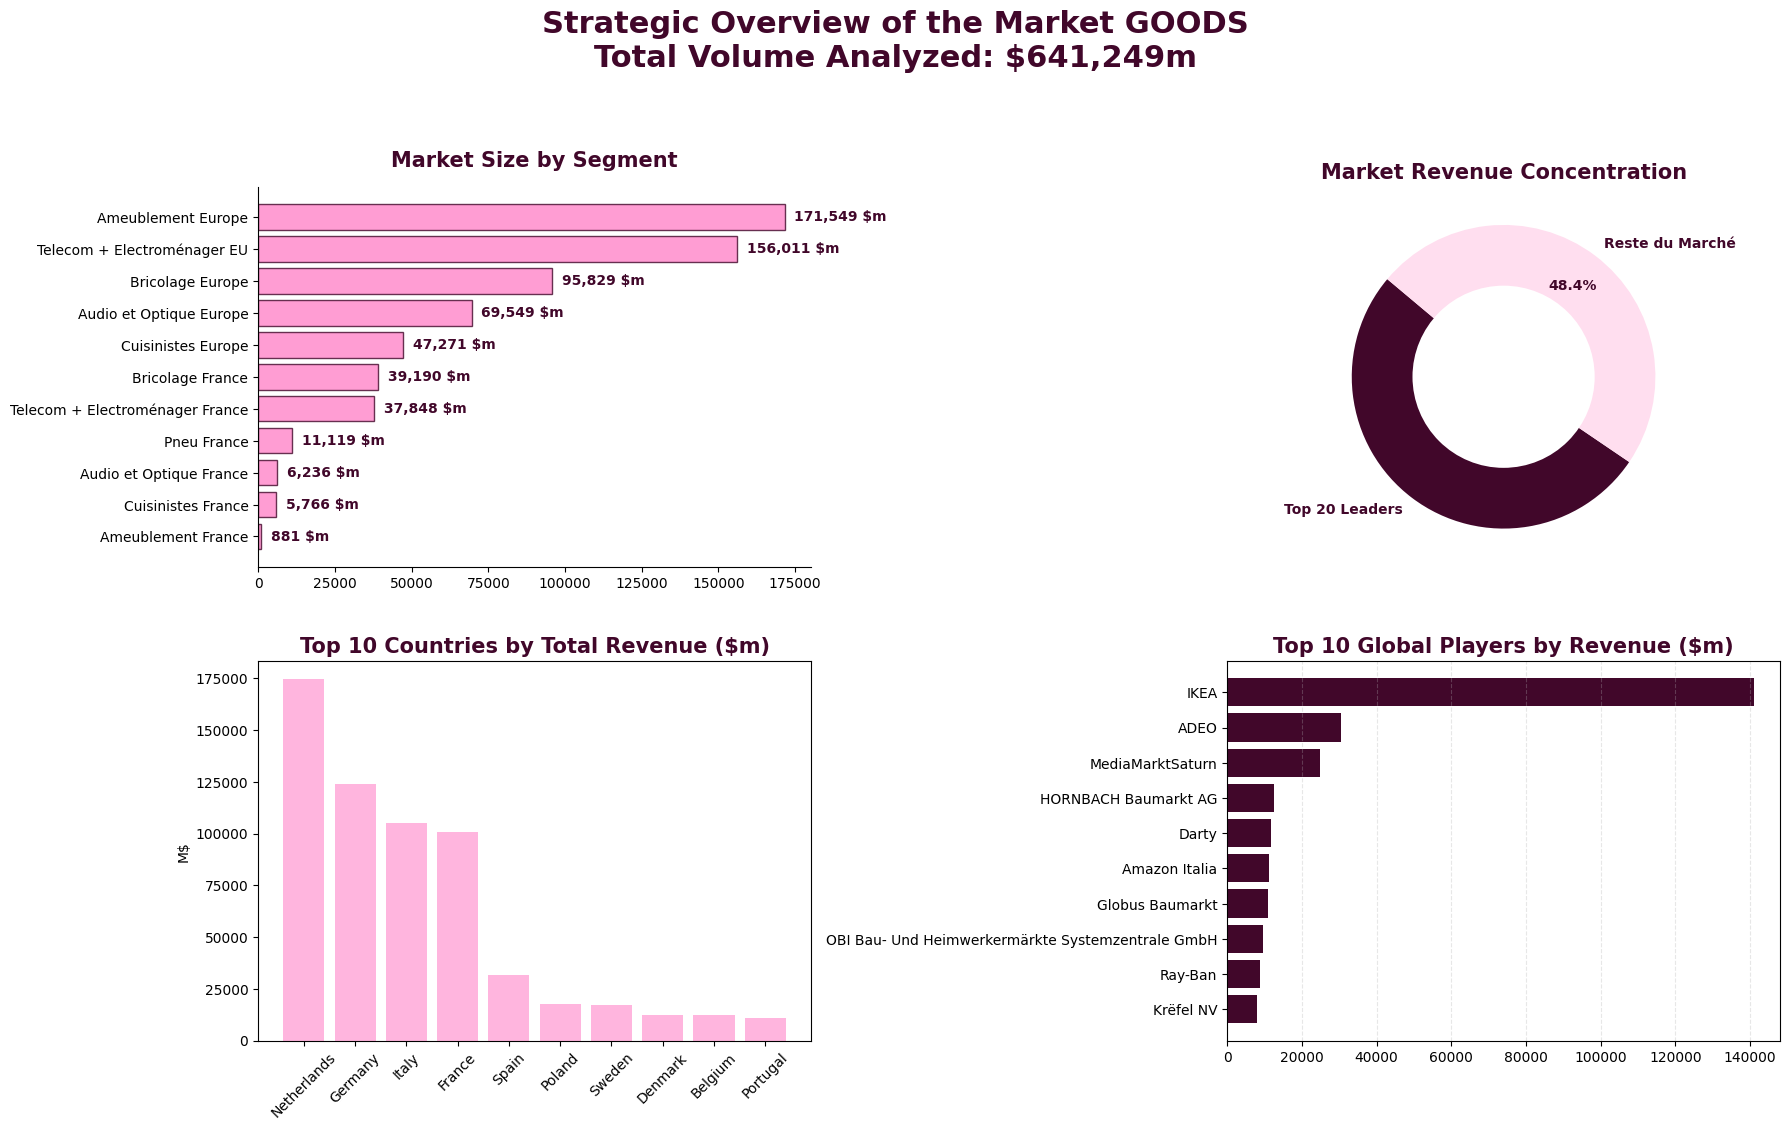

In [165]:
generer_panorama_final(data_goods, "Goods")

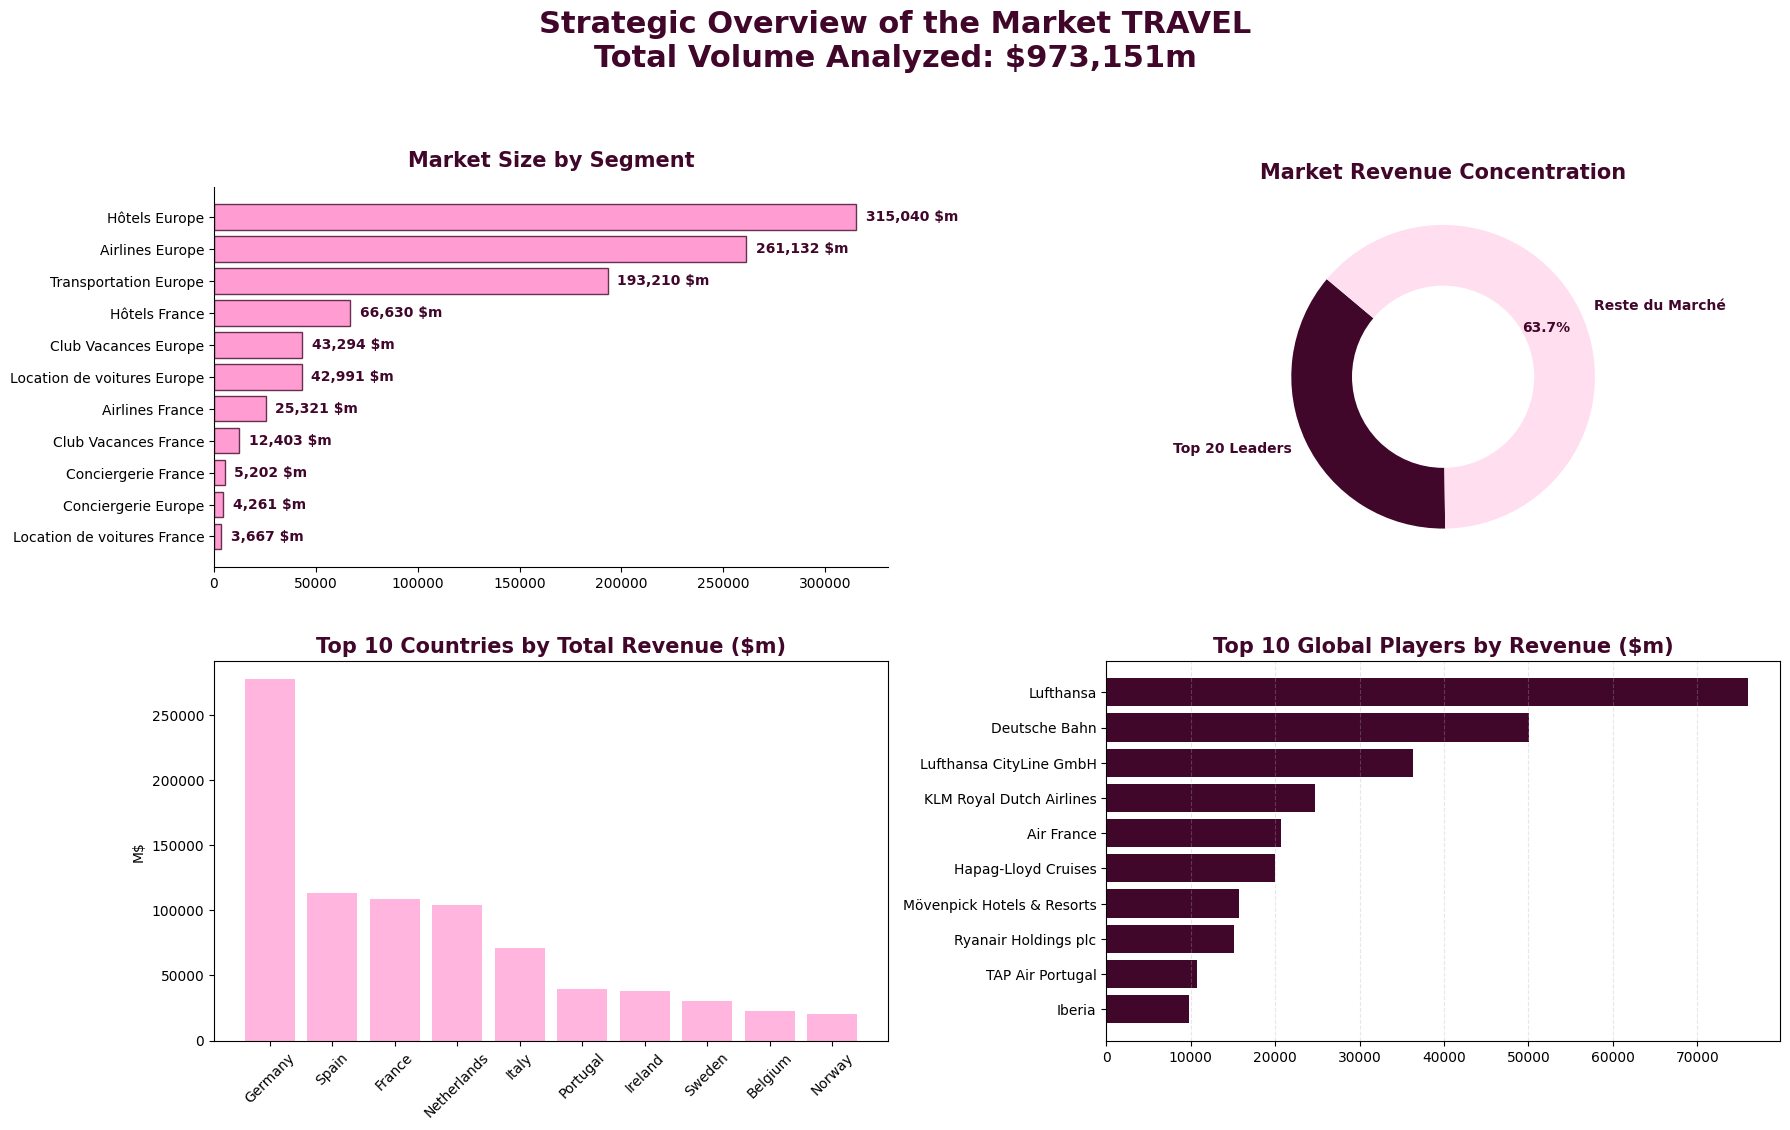

In [125]:
generer_panorama_final(data_travel,"Travel")